In [1]:
INPUT_PATH = "outputs_notebook02/final_scored_dataset_sampleA.parquet"

In [2]:
import os, shutil

os.makedirs("outputs_notebook02", exist_ok=True)

src = "./final_scored_dataset_sampleA.parquet"
dst = "outputs_notebook02/final_scored_dataset_sampleA.parquet"

# 保险：如果已经在 dst，就不重复移动
if os.path.exists(src) and not os.path.exists(dst):
    shutil.move(src, dst)

print("Exists src?", os.path.exists(src))
print("Exists dst?", os.path.exists(dst))

Exists src? False
Exists dst? True


In [3]:
import pandas as pd
import numpy as np
import os

# 1) Load
SAVE_DIR = "outputs_notebook02"   # or "."
DATA_PATH = os.path.join(SAVE_DIR, "final_scored_dataset_sampleA.parquet")
df = pd.read_parquet(DATA_PATH)

# 2) Inject unit_id
if "unit_id" not in df.columns:
    df.insert(0, "unit_id", [f"U_{i:06d}" for i in range(len(df))])

# 3) Identify model uplift columns (exclude *_rank)
uplift_model_cols = [c for c in df.columns if c.startswith("uplift_") and not c.endswith("_rank")]
# e.g. uplift_tlearner, uplift_dml, uplift_cf

# 4) Rank-normalized scores for ranking policies
for col in uplift_model_cols:
    model = col.replace("uplift_", "")  # tlearner / dml / cf
    df[f"score_{model}"] = df[col].rank(pct=True)

# 5) Choose default model (prefer dml > cf > tlearner)
if "uplift_dml" in df.columns:
    BEST_MODEL = "dml"
elif "uplift_cf" in df.columns:
    BEST_MODEL = "cf"
else:
    BEST_MODEL = "tlearner"

# 6) Score contract: keep both uplift($) and score(rank)
df["targeting_uplift"] = df[f"uplift_{BEST_MODEL}"]      # for profit layer
df["targeting_score"]  = df[f"score_{BEST_MODEL}"]       # for ranking/top-K

print("✅ Score Contract Established")
print("Main Model:", BEST_MODEL)
print(df[["unit_id", "targeting_uplift", "targeting_score"]].head())
print("Available uplift cols:", uplift_model_cols)

✅ Score Contract Established
Main Model: dml
    unit_id  targeting_uplift  targeting_score
0  U_000000         -7.127705         0.012026
1  U_000001         22.426935         0.892363
2  U_000002         11.024338         0.418521
3  U_000003         -1.759019         0.042093
4  U_000004          6.556398         0.218280
Available uplift cols: ['uplift_tlearner', 'uplift_dml', 'uplift_cf']


In [4]:
# ==========================================
# P0-2 Profit Layer & Simulator Function
# ==========================================

def simulate_policy_profit(df, margin=0.30, cost=2.0, budget=None, uplift_col="targeting_uplift"):
    """
    策略模拟器：执行 '利润最大化' 逻辑 (Gate -> Sort -> Budget)
    """
    temp = df[["unit_id", uplift_col, "targeting_score"]].copy()

    # 1. 计算个体增量利润 (Profit Layer)
    temp["expected_inc_profit"] = temp[uplift_col] * margin - cost

    # 2. 门控：剔除任何预期利润为负的人 (Profit Gate)
    temp = temp[temp["expected_inc_profit"] > 0].copy()

    # 3. 排序：按利润贡献降序排列 (Profit-max sorting)
    temp = temp.sort_values("expected_inc_profit", ascending=False).reset_index(drop=True)

    # 4. 预算约束：在赚钱的人里按预算截断 (Budget constraint)
    if budget is not None:
        if cost <= 0:
            raise ValueError("cost must be > 0 when budget is used.")
        max_users = int(budget // cost)
        temp = temp.head(max_users)


    # 计算指标
    n = len(temp)
    total_profit = float(temp["expected_inc_profit"].sum())
    total_cost = n * cost
    roi = (total_profit / total_cost) if total_cost > 0 else 0.0
    coverage = (n / len(df)) * 100 if len(df) > 0 else 0.0

    return {
        "n_targeted": n,
        "coverage_pct": round(coverage, 2),
        "total_profit": round(total_profit, 2),
        "total_cost": round(total_cost, 2),
        "roi": round(roi, 4),
        "target_df": temp # 返回目标清单
    }

# --- 业务参数配置 ---
MARGIN = 0.30
COUPON_COST = 2.00
BUDGET_TOTAL = 500.00

# ==========================================
# P0-3 & P0-4 Policy Execution
# ==========================================

# 1. 执行 Policy A: Threshold Policy (无预算限制，只看潜力)
res_a = simulate_policy_profit(df, margin=MARGIN, cost=COUPON_COST, budget=None)

print(f"=== Policy A: Threshold (Profit > 0) ===")
print(f"Targeted: {res_a['n_targeted']} ({res_a['coverage_pct']}%)")
print(f"Total Profit: ${res_a['total_profit']}")
print(f"Total Cost: ${res_a['total_cost']}")
print(f"ROI: {res_a['roi']}")

# 2. 执行 Policy B: Budget-Constrained (利润最大化)
res_b = simulate_policy_profit(df, margin=MARGIN, cost=COUPON_COST, budget=BUDGET_TOTAL)

print(f"\n=== Policy B: Budget-Constrained (${BUDGET_TOTAL}) ===")
print(f"Targeted: {res_b['n_targeted']}")
print(f"Total Profit: ${res_b['total_profit']}")
print(f"Total Cost: ${res_b['total_cost']}")
print(f"ROI: {res_b['roi']}")

# 展示最终的 Target List (Top 10)
display(
    res_b["target_df"][["unit_id", "targeting_uplift", "expected_inc_profit", "targeting_score"]]
    .head(10)
)

=== Policy A: Threshold (Profit > 0) ===
Targeted: 1295 (77.87%)
Total Profit: $3466.56
Total Cost: $2590.0
ROI: 1.3384

=== Policy B: Budget-Constrained ($500.0) ===
Targeted: 250
Total Profit: $1370.08
Total Cost: $500.0
ROI: 2.7402


,unit_id,targeting_uplift,expected_inc_profit,targeting_score
0,U_001467,45.385684,11.615705,1.000000
1,U_001588,35.994373,8.798312,0.999399
2,U_001272,34.693428,8.408029,0.998797
3,U_000370,33.339043,8.001713,0.998196
4,U_001537,33.125495,7.937648,0.997595
5,U_000954,32.805320,7.841596,0.996993
6,U_000465,32.063805,7.619141,0.996392
7,U_000738,31.797151,7.539145,0.995791
8,U_000992,31.722385,7.516716,0.995189
9,U_000536,31.533488,7.460046,0.994588


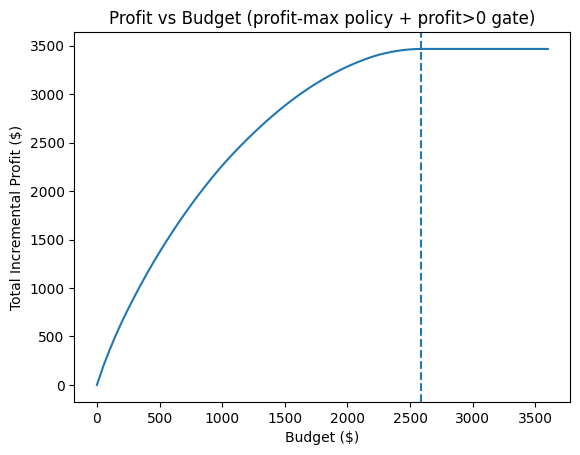

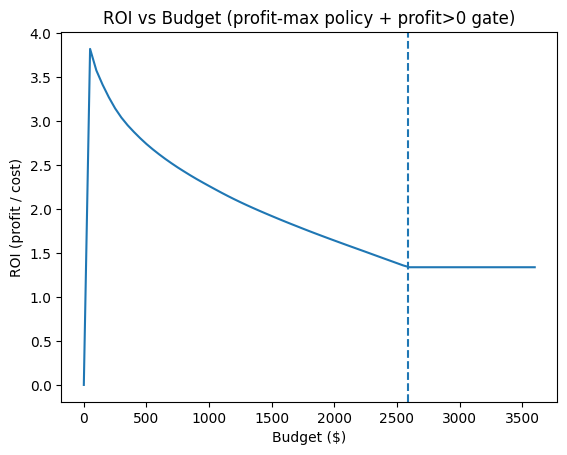

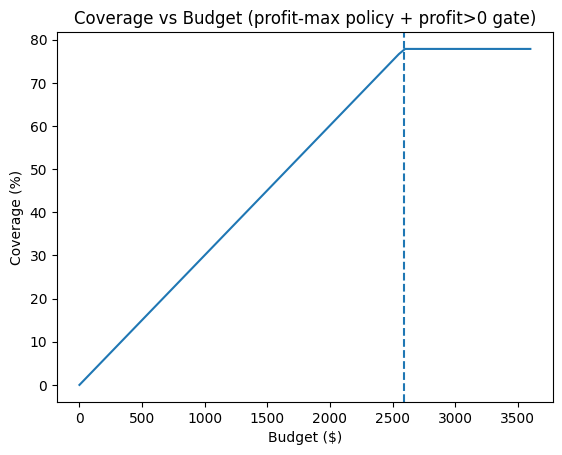

Saturation budget (dashed line): ~$2590


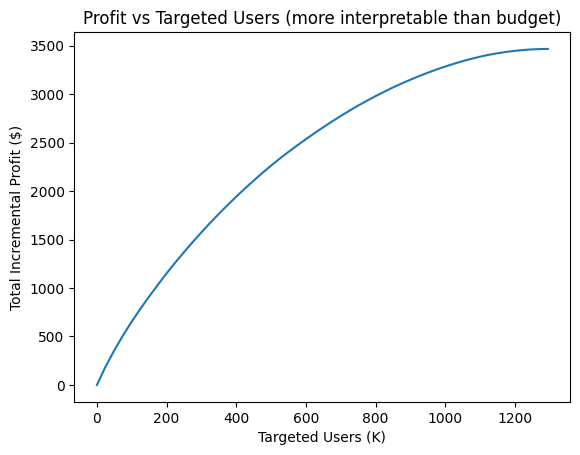

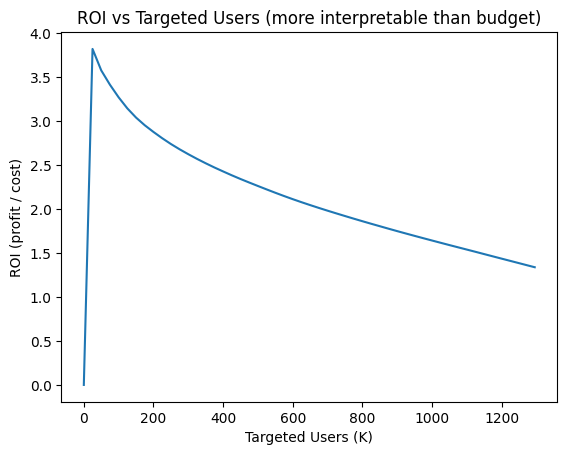


Key budget checkpoints:


,budget,n_targeted,coverage_pct,total_cost,total_profit,roi
0,0.0,0,0.00,0.0,0.00,0.0000
10,500.0,250,15.03,500.0,1370.08,2.7402
20,1000.0,500,30.07,1000.0,2262.40,2.2624
40,2000.0,1000,60.13,2000.0,3284.89,1.6424
72,3600.0,1295,77.87,2590.0,3466.56,1.3384


In [5]:
# ==========================================
# P0-5 Curves: Profit / ROI / Coverage vs Budget
# + (recommended) vs Targeted Users
# ==========================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- Assumes these already exist from P0-2~P0-4 ----
# df
# simulate_policy_profit(df, margin=..., cost=..., budget=..., uplift_col="targeting_uplift")
# MARGIN, COUPON_COST
# res_a (threshold result) is optional but recommended (for saturation line)

# -----------------------------
# 1) Sweep budgets
# -----------------------------
# Choose a budget range: up to "full saturation" or a bit beyond for visualization
# Saturation budget = (# profitable users under threshold) * cost
# If you already computed res_a = simulate_policy_profit(..., budget=None), use it:
if "res_a" in globals() and isinstance(res_a, dict):
    budget_sat = float(res_a["n_targeted"] * COUPON_COST)
else:
    # fallback: estimate saturation by running once (no budget)
    _tmp = simulate_policy_profit(df, margin=MARGIN, cost=COUPON_COST, budget=None)
    budget_sat = float(_tmp["n_targeted"] * COUPON_COST)

max_budget = int(np.ceil(budget_sat / 100.0) * 100 + 1000)  # a bit beyond saturation
step = 50  # budget step size; smaller => smoother but slower

budgets = np.arange(0, max_budget + step, step)

rows = []
for b in budgets:
    res = simulate_policy_profit(
        df,
        margin=MARGIN,
        cost=COUPON_COST,
        budget=float(b),
        uplift_col="targeting_uplift"
    )
    # IMPORTANT: use raw numeric fields; avoid rounding artifacts in curves
    n = int(res["n_targeted"])
    total_cost = n * COUPON_COST
    total_profit = float(res["target_df"]["expected_inc_profit"].sum()) if n > 0 else 0.0
    roi = (total_profit / total_cost) if total_cost > 0 else 0.0
    coverage_pct = (n / len(df) * 100.0) if len(df) > 0 else 0.0

    rows.append({
        "budget": float(b),
        "n_targeted": n,
        "coverage_pct": coverage_pct,
        "total_cost": total_cost,
        "total_profit": total_profit,
        "roi": roi,
    })

curve = pd.DataFrame(rows)

# -----------------------------
# 2) Plot vs Budget (3 charts)
# -----------------------------
# Profit vs Budget
plt.figure()
plt.plot(curve["budget"], curve["total_profit"])
plt.axvline(budget_sat, linestyle="--")
plt.xlabel("Budget ($)")
plt.ylabel("Total Incremental Profit ($)")
plt.title("Profit vs Budget (profit-max policy + profit>0 gate)")
plt.show()

# ROI vs Budget
plt.figure()
plt.plot(curve["budget"], curve["roi"])
plt.axvline(budget_sat, linestyle="--")
plt.xlabel("Budget ($)")
plt.ylabel("ROI (profit / cost)")
plt.title("ROI vs Budget (profit-max policy + profit>0 gate)")
plt.show()

# Coverage vs Budget
plt.figure()
plt.plot(curve["budget"], curve["coverage_pct"])
plt.axvline(budget_sat, linestyle="--")
plt.xlabel("Budget ($)")
plt.ylabel("Coverage (%)")
plt.title("Coverage vs Budget (profit-max policy + profit>0 gate)")
plt.show()

print(f"Saturation budget (dashed line): ~${budget_sat:.0f}")

# -----------------------------
# 3) Recommended: Plot vs Targeted Users (2 charts)
# -----------------------------
# Sort by n_targeted so the x-axis is monotonic even if budgets repeat
curve_k = curve.sort_values("n_targeted").drop_duplicates("n_targeted")

# Profit vs Targeted Users
plt.figure()
plt.plot(curve_k["n_targeted"], curve_k["total_profit"])
plt.xlabel("Targeted Users (K)")
plt.ylabel("Total Incremental Profit ($)")
plt.title("Profit vs Targeted Users (more interpretable than budget)")
plt.show()

# ROI vs Targeted Users
plt.figure()
plt.plot(curve_k["n_targeted"], curve_k["roi"])
plt.xlabel("Targeted Users (K)")
plt.ylabel("ROI (profit / cost)")
plt.title("ROI vs Targeted Users (more interpretable than budget)")
plt.show()

# -----------------------------
# 4) Quick table: key budgets
# -----------------------------
checkpoints = [0, 500, 1000, 2000, int(budget_sat), max_budget]
checkpoints = sorted(set([b for b in checkpoints if 0 <= b <= max_budget]))

summary = curve[curve["budget"].isin(checkpoints)].copy()
summary["total_profit"] = summary["total_profit"].round(2)
summary["roi"] = summary["roi"].round(4)
summary["coverage_pct"] = summary["coverage_pct"].round(2)
summary["total_cost"] = summary["total_cost"].round(2)

print("\nKey budget checkpoints:")
display(summary)

# If you want to save for report:
# curve.to_csv("outputs_notebook03/p0_budget_sweep_curves.csv", index=False)

In [6]:
# sensitivity analysis
import numpy as np
import pandas as pd

# ---- choose sensitivity grids ----
MARGINS = [0.20, 0.30, 0.40, 0.50]
COSTS   = [1.0, 2.0, 3.0, 5.0]
BUDGETS = [500, 1000, 2000]   # 你也可以只用 [500]

rows = []
for b in BUDGETS:
    for m in MARGINS:
        for c in COSTS:
            res = simulate_policy_profit(df, margin=m, cost=c, budget=b, uplift_col="targeting_uplift")
            rows.append({
                "budget": float(b),
                "margin": float(m),
                "cost": float(c),
                "n_targeted": int(res["n_targeted"]),
                "coverage_pct": float(res["coverage_pct"]),
                "total_profit": float(res["total_profit"]),
                "total_cost": float(res["total_cost"]),
                "roi": float(res["roi"]),
            })

sens = pd.DataFrame(rows)

# ---- quick views ----
# 1) Top ROI settings under each budget
top_roi = (sens.sort_values(["budget","roi"], ascending=[True, False])
               .groupby("budget")
               .head(8)
               .reset_index(drop=True))

# 2) Top Profit settings under each budget
top_profit = (sens.sort_values(["budget","total_profit"], ascending=[True, False])
                  .groupby("budget")
                  .head(8)
                  .reset_index(drop=True))

print("Top ROI settings by budget:")
display(top_roi)

print("\nTop Profit settings by budget:")
display(top_profit)

# 3) A neat pivot for one budget (e.g., 500): ROI heatmap-like table (no seaborn)
b0 = 500
pivot_roi = (sens[sens["budget"]==b0]
             .pivot(index="margin", columns="cost", values="roi")
             .sort_index())
pivot_profit = (sens[sens["budget"]==b0]
                .pivot(index="margin", columns="cost", values="total_profit")
                .sort_index())

print(f"\nROI table at budget=${b0}:")
display(pivot_roi)

print(f"\nTotal Profit table at budget=${b0}:")
display(pivot_profit)

Top ROI settings by budget:


,budget,margin,cost,n_targeted,coverage_pct,total_profit,total_cost,roi
0,500.0,0.5,1.0,500,30.07,4937.34,500.0,9.8747
1,500.0,0.4,1.0,500,30.07,3849.87,500.0,7.6997
2,500.0,0.3,1.0,500,30.07,2762.40,500.0,5.5248
3,500.0,0.5,2.0,250,15.03,2616.80,500.0,5.2336
4,500.0,0.4,2.0,250,15.03,1993.44,500.0,3.9869
5,500.0,0.5,3.0,166,9.98,1705.86,498.0,3.4254
6,500.0,0.2,1.0,500,30.07,1674.94,500.0,3.3499
7,500.0,0.3,2.0,250,15.03,1370.08,500.0,2.7402
8,1000.0,0.5,1.0,1000,60.13,7808.15,1000.0,7.8081
9,1000.0,0.4,1.0,1000,60.13,6046.52,1000.0,6.0465



Top Profit settings by budget:


,budget,margin,cost,n_targeted,coverage_pct,total_profit,total_cost,roi
0,500.0,0.5,1.0,500,30.07,4937.34,500.0,9.8747
1,500.0,0.4,1.0,500,30.07,3849.87,500.0,7.6997
2,500.0,0.3,1.0,500,30.07,2762.40,500.0,5.5248
3,500.0,0.5,2.0,250,15.03,2616.80,500.0,5.2336
4,500.0,0.4,2.0,250,15.03,1993.44,500.0,3.9869
5,500.0,0.5,3.0,166,9.98,1705.86,498.0,3.4254
6,500.0,0.2,1.0,500,30.07,1674.94,500.0,3.3499
7,500.0,0.3,2.0,250,15.03,1370.08,500.0,2.7402
8,1000.0,0.5,1.0,1000,60.13,7808.15,1000.0,7.8081
9,1000.0,0.4,1.0,1000,60.13,6046.52,1000.0,6.0465



ROI table at budget=$500:


cost,1.0,2.0,3.0,5.0
margin,,,,
0.2,3.3499,1.4934,0.7702,0.1450
0.3,5.5248,2.7402,1.6553,0.7083
0.4,7.6997,3.9869,2.5403,1.2777
0.5,9.8747,5.2336,3.4254,1.8471



Total Profit table at budget=$500:


cost,1.0,2.0,3.0,5.0
margin,,,,
0.2,1674.94,746.72,383.54,69.59
0.3,2762.40,1370.08,824.32,354.14
0.4,3849.87,1993.44,1265.09,638.85
0.5,4937.34,2616.80,1705.86,923.57


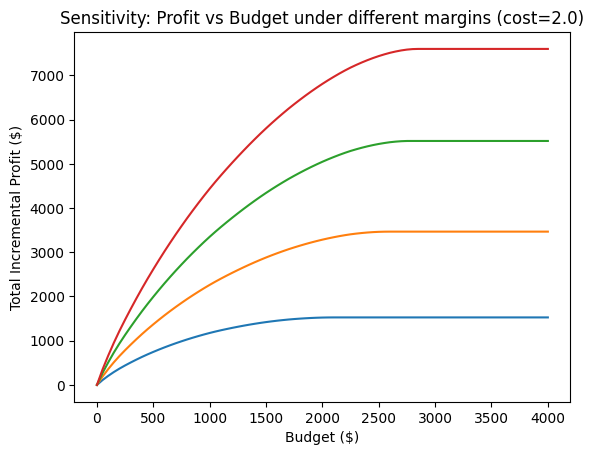

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

fixed_cost = 2.0
margins_to_plot = [0.2, 0.3, 0.4, 0.5]
budgets = np.arange(0, 4000+50, 50)

plt.figure()
for m in margins_to_plot:
    profits = []
    for b in budgets:
        res = simulate_policy_profit(df, margin=m, cost=fixed_cost, budget=float(b), uplift_col="targeting_uplift")
        # 用 target_df 的 sum 避免 round 造成锯齿
        n = res["n_targeted"]
        prof = float(res["target_df"]["expected_inc_profit"].sum()) if n > 0 else 0.0
        profits.append(prof)
    plt.plot(budgets, profits)

plt.xlabel("Budget ($)")
plt.ylabel("Total Incremental Profit ($)")
plt.title(f"Sensitivity: Profit vs Budget under different margins (cost={fixed_cost})")
plt.show()

=== P1-3: Quad-Tree Summary Table ===


,user_count,share_pct,uplift_mean,uplift_median,baseline_mean,baseline_median
segment,,,,,,
Persuadables,456,27.4203,18.7309,17.7898,2.2551,0.000
Sure Things,379,22.7901,7.1957,7.5721,78.5704,61.530
High-High,376,22.6097,18.9617,17.8155,79.5312,63.855
Lost Causes,342,20.5652,8.1213,9.0703,4.4196,1.170
Sleeping Dogs,110,6.6146,-3.9536,-2.5654,124.4375,44.615



=== Policy B Coverage by Segment (optional) ===


,segment_size,targeted_count,targeted_pct,avg_profit_if_targeted
segment,,,,
High-High,376,120,31.91,18.961730
Lost Causes,342,0,0.00,8.121252
Persuadables,456,130,28.51,18.730919
Sleeping Dogs,110,0,0.00,-3.953596
Sure Things,379,0,0.00,7.195660


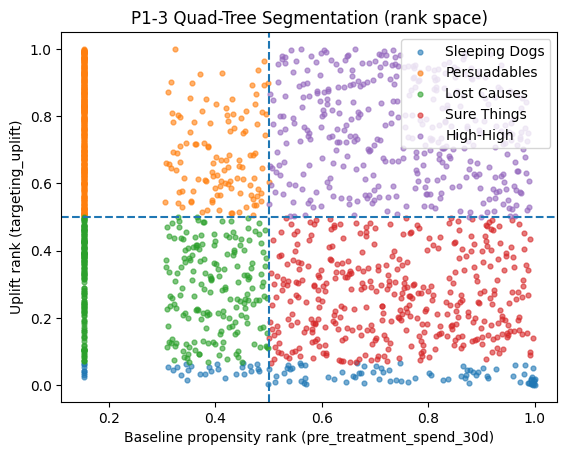


Segment counts:
segment
Persuadables     456
Sure Things      379
High-High        376
Lost Causes      342
Sleeping Dogs    110
Name: count, dtype: int64

Negative uplift share (%): 6.61


In [8]:
# ==========================================
# P1-3: Segment Insights (Quad-Tree / 2x2 Archetypes)
#   - Baseline axis: pre_treatment_spend_30d (baseline propensity)
#   - Uplift axis: targeting_uplift ($ spend uplift, signed)
#   - Sleeping Dogs: uplift < 0 (explicitly separated)
#   - Remaining users: 2x2 split by median ranks (uplift rank vs baseline rank)
#
# Outputs:
#   1) quadrant_summary: counts, shares, avg/median uplift & baseline
#   2) segment_policy_coverage: how much each segment is covered by a policy (optional)
#   3) scatter plot: rank_baseline vs rank_uplift colored by segment
# ==========================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# 0) Choose axes (plan-consistent)
# -----------------------------
BASELINE_COL = "pre_treatment_spend_30d"
UPLIFT_COL = "targeting_uplift"          # signed $ uplift
SCORE_COL = "targeting_score"            # 0~1 rank score (optional reference)
ID_COL = "unit_id"

assert BASELINE_COL in df.columns, f"Missing baseline column: {BASELINE_COL}"
assert UPLIFT_COL in df.columns, f"Missing uplift column: {UPLIFT_COL}"
assert ID_COL in df.columns, f"Missing id column: {ID_COL}"

# -----------------------------
# 1) Rank-normalize axes to [0,1] for robust quadrant splits
# -----------------------------
# Use percentile ranks to reduce sensitivity to outliers.
df["rank_baseline"] = df[BASELINE_COL].rank(pct=True)
df["rank_uplift"] = df[UPLIFT_COL].rank(pct=True)

# Median cutoffs (0.5 in percentile rank space)
U_CUT = 0.5
B_CUT = 0.5

# -----------------------------
# 2) Define archetypes
# -----------------------------
# We explicitly separate negative uplift as "Sleeping Dogs" to avoid mixing with low-uplift positives.
def assign_segment(row, u_cut=U_CUT, b_cut=B_CUT):
    u = row[UPLIFT_COL]
    ru = row["rank_uplift"]
    rb = row["rank_baseline"]

    # Explicit negative uplift group
    if pd.notna(u) and u < 0:
        return "Sleeping Dogs"  # potentially harmed by treatment

    high_uplift = ru > u_cut
    high_base = rb > b_cut

    if high_uplift and (not high_base):
        return "Persuadables"   # high uplift, low baseline (best incremental targets)
    if (not high_uplift) and high_base:
        return "Sure Things"    # low uplift, high baseline (likely to buy anyway)
    if (not high_uplift) and (not high_base):
        return "Lost Causes"    # low uplift, low baseline
    return "High-High"          # high uplift, high baseline (valuable but not the classic "sure thing")

df["segment"] = df.apply(assign_segment, axis=1)

# -----------------------------
# 3) Summary table (deliverable)
# -----------------------------
quadrant_summary = (
    df.groupby("segment")
      .agg(
          user_count=(ID_COL, "count"),
          share_pct=(ID_COL, lambda x: 100.0 * len(x) / len(df)),
          uplift_mean=(UPLIFT_COL, "mean"),
          uplift_median=(UPLIFT_COL, "median"),
          baseline_mean=(BASELINE_COL, "mean"),
          baseline_median=(BASELINE_COL, "median"),
      )
      .sort_values("user_count", ascending=False)
)

# Optional: round for display (keep raw df untouched)
quadrant_summary_display = quadrant_summary.copy()
for c in ["share_pct", "uplift_mean", "uplift_median", "baseline_mean", "baseline_median"]:
    quadrant_summary_display[c] = quadrant_summary_display[c].round(4)

print("=== P1-3: Quad-Tree Summary Table ===")
display(quadrant_summary_display)

# -----------------------------
# 4) (Optional) Policy coverage by segment
# -----------------------------
# If you have a target list from your simulator (e.g., res_b['target_df']),
# we can compute what fraction of each segment is selected by the policy.
# Expected: res_b['target_df'] contains 'unit_id' for targeted users.
segment_policy_coverage = None
if "res_b" in globals() and isinstance(res_b, dict) and "target_df" in res_b:
    targeted_ids = set(res_b["target_df"][ID_COL].astype(str).tolist())
    df["_is_targeted_policyB"] = df[ID_COL].astype(str).isin(targeted_ids)

    segment_policy_coverage = (
        df.groupby("segment")
          .agg(
              segment_size=(ID_COL, "count"),
              targeted_count=("_is_targeted_policyB", "sum"),
              targeted_pct=("_is_targeted_policyB", lambda x: 100.0 * x.mean()),
              avg_profit_if_targeted=("inc_profit", "mean") if "inc_profit" in df.columns else (UPLIFT_COL, "mean"),
          )
    )
    segment_policy_coverage_display = segment_policy_coverage.copy()
    for c in ["targeted_pct"]:
        segment_policy_coverage_display[c] = segment_policy_coverage_display[c].round(2)

    print("\n=== Policy B Coverage by Segment (optional) ===")
    display(segment_policy_coverage_display)

# -----------------------------
# 5) Scatter plot: rank_baseline vs rank_uplift (colored by segment)
# -----------------------------
# Note: Avoid specifying colors explicitly per your plotting preference.
plt.figure()
for seg in df["segment"].unique():
    sub = df[df["segment"] == seg]
    plt.scatter(sub["rank_baseline"], sub["rank_uplift"], label=seg, s=12, alpha=0.6)

plt.axvline(B_CUT, linestyle="--")
plt.axhline(U_CUT, linestyle="--")
plt.xlabel("Baseline propensity rank (pre_treatment_spend_30d)")
plt.ylabel("Uplift rank (targeting_uplift)")
plt.title("P1-3 Quad-Tree Segmentation (rank space)")
plt.legend()
plt.show()

# -----------------------------
# 6) Quick sanity checks (optional prints)
# -----------------------------
print("\nSegment counts:")
print(df["segment"].value_counts())

print("\nNegative uplift share (%):", round(100.0 * (df[UPLIFT_COL] < 0).mean(), 2))

In [9]:
# -----------------------------
# 7) P1-4 Segment Differentiation: Persuadables vs Sure Things
# -----------------------------
print("\n=== P1-4: Insight - Persuadables vs Sure Things ===")

compare_features = ['age', 'income', 'pre_treatment_spend_30d', 'user_tenure_days']
valid_features = [f for f in compare_features if f in df.columns]

if ("Persuadables" in df["segment"].values) and ("Sure Things" in df["segment"].values):
    p_df = df[df["segment"] == "Persuadables"][valid_features]
    s_df = df[df["segment"] == "Sure Things"][valid_features]

    # Use both mean and median (robust to skew)
    p_mean, s_mean = p_df.mean(), s_df.mean()
    p_med,  s_med  = p_df.median(), s_df.median()

    eps = 1e-9  # avoid divide-by-zero

    diff_mean_pct = ((p_mean - s_mean) / (s_mean.abs() + eps) * 100).round(2)
    diff_med_pct  = ((p_med  - s_med)  / (s_med.abs()  + eps) * 100).round(2)

    for feat in valid_features:
        dm = diff_mean_pct[feat]
        dmed = diff_med_pct[feat]

        status_m = "low" if dm < 0 else "high"
        status_med = "low" if dmed < 0 else "high"

        print(f"[{feat}] Mean: Persuadables vs Sure Things mean{status_m} {abs(dm)}% | "
              f"Median: median{status_med} {abs(dmed)}%")
else:
    print("Warning: Persuadables or Sure Things not found in segments.")


=== P1-4: Insight - Persuadables vs Sure Things ===
[age] Mean: Persuadables vs Sure Things meanhigh 3.88% | Median: medianhigh 1.85%
[income] Mean: Persuadables vs Sure Things meanhigh 18.34% | Median: medianhigh 18.97%
[pre_treatment_spend_30d] Mean: Persuadables vs Sure Things meanlow 97.13% | Median: medianlow 100.0%
[user_tenure_days] Mean: Persuadables vs Sure Things meanlow 33.77% | Median: medianlow 64.51%


Using target flag column: _is_targeted_policyB
Group A (Targeted Persuadables): 130 users
Group B (Avoided Sure Things): 379 users

=== P1-4: Deliverable - Profile Contrast Table (Targeted vs Avoided) ===


,Targeted_Mean,Avoided_Mean,DiffMean_%,Targeted_Median,Avoided_Median,DiffMedian_%,n_Targeted,n_Avoided
Feature,,,,,,,,
age,61.38,52.73,16.4,60.0,54.00,11.1,130,379
income,91446.15,59620.05,53.4,93000.0,58000.00,60.3,130,379
user_tenure_days,270.98,428.82,-36.8,122.0,324.00,-62.3,130,379
pre_treatment_spend_30d,1.07,78.57,-98.6,0.0,61.53,-100.0,130,379


/tmp/ipython-input-3677649233.py:110: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, i].boxplot(
/tmp/ipython-input-3677649233.py:110: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, i].boxplot(
/tmp/ipython-input-3677649233.py:110: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, i].boxplot(
/tmp/ipython-input-3677649233.py:110: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, i].boxplot(


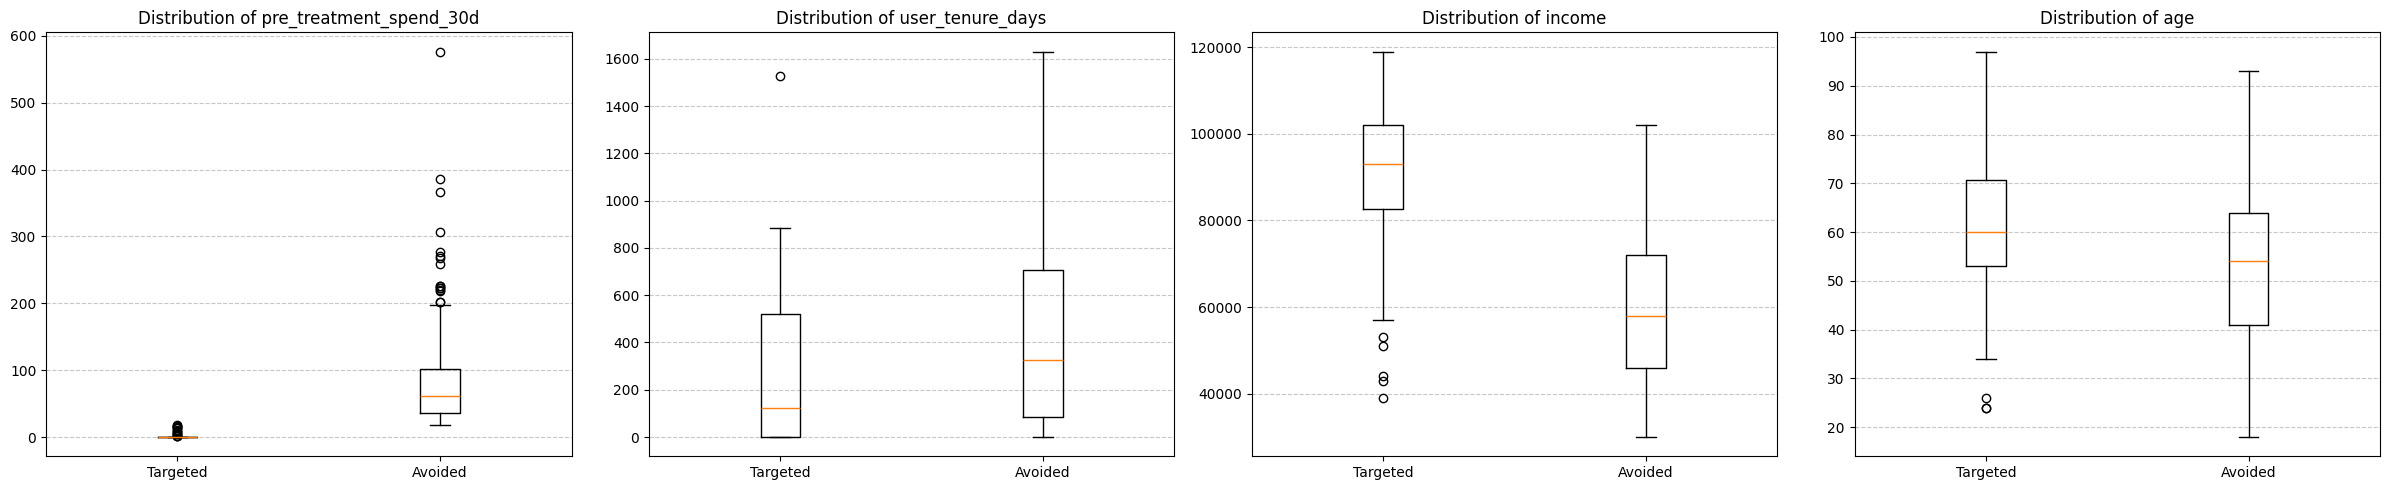


=== P1-4: Strategic Insights (Hypotheses) ===
- Targeted Persuadables have 100.0% lower median baseline spend than avoided Sure Things, which aligns with the intent to avoid subsidizing natural buyers.
- Targeted users show 62.3% shorter median tenure, suggesting the policy may prioritize distinct relationship stages (e.g., newer vs established members).
- Targeted users have 60.3% higher median income than avoided users; this could be explored as a hypothesis for differential responsiveness to incentives.


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# P1-4: Final Missing Puzzle - Policy Contrast Analysis (FINAL)
# Goal:
#   Convert model output into concrete business insights about:
#   - Who we actually target (Policy-selected high-quality targets)
#   - Who we intentionally avoid (wasteful/natural buyers)
#
# Group definitions (plan-consistent):
#   Group A = Persuadables ∩ PolicyB_selected
#   Group B = Sure Things ∩ PolicyB_not_selected
#
# Deliverables:
#   1) Compact table: mean/median + %diff (mean and median) for key features
#   2) 2 distribution plots (boxplots) for high-impact features
#   3) 2–3 safe business hypotheses (no over-claiming causality)
# ==========================================

# -----------------------------
# 0) Find the policy target flag column robustly
# -----------------------------
TARGET_FLAG_COL = None
for c in ["_is_targeted_policyB", "_is_targeted", "policy_b_target"]:
    if c in df.columns:
        TARGET_FLAG_COL = c
        break

if TARGET_FLAG_COL is None:
    raise ValueError(
        "No policy target flag found. Please create one from res_b['target_df'] (unit_id) first. "
        "Expected columns: _is_targeted_policyB / _is_targeted / policy_b_target"
    )

# -----------------------------
# 1) Define strict contrast groups based on ACTUAL Policy B decisions
# -----------------------------
df_a = df[(df["segment"] == "Persuadables") & (df[TARGET_FLAG_COL] == True)].copy()
df_b = df[(df["segment"] == "Sure Things") & (df[TARGET_FLAG_COL] == False)].copy()

print(f"Using target flag column: {TARGET_FLAG_COL}")
print(f"Group A (Targeted Persuadables): {len(df_a)} users")
print(f"Group B (Avoided Sure Things): {len(df_b)} users")

if len(df_a) == 0 or len(df_b) == 0:
    print("Warning: One of the groups is empty. Check segment labels and policy flag logic.")

# -----------------------------
# 2) Select features for contrast (safe selection)
# -----------------------------
features_to_contrast = ["age", "income", "user_tenure_days", "pre_treatment_spend_30d"]
valid_feats = [f for f in features_to_contrast if f in df.columns]

if len(valid_feats) == 0:
    raise ValueError("No valid contrast features found in df. Please check your column names.")

# -----------------------------
# 3) Build compact table (Mean, Median, and % Differences for BOTH mean & median)
# -----------------------------
eps = 1e-9
contrast_rows = []

for f in valid_feats:
    a = df_a[f].dropna()
    b = df_b[f].dropna()

    m_a, med_a = a.mean(), a.median()
    m_b, med_b = b.mean(), b.median()

    diff_mean_pct = ((m_a - m_b) / (abs(m_b) + eps)) * 100
    diff_med_pct  = ((med_a - med_b) / (abs(med_b) + eps)) * 100

    contrast_rows.append({
        "Feature": f,
        "Targeted_Mean": round(float(m_a), 2),
        "Avoided_Mean": round(float(m_b), 2),
        "DiffMean_%": round(float(diff_mean_pct), 1),
        "Targeted_Median": round(float(med_a), 2),
        "Avoided_Median": round(float(med_b), 2),
        "DiffMedian_%": round(float(diff_med_pct), 1),
        "n_Targeted": int(a.shape[0]),
        "n_Avoided": int(b.shape[0]),
    })

summary_table = pd.DataFrame(contrast_rows).set_index("Feature")
print("\n=== P1-4: Deliverable - Profile Contrast Table (Targeted vs Avoided) ===")
display(summary_table)

# -----------------------------
# 4) Visualization: dynamic number of subplots (robust)
# -----------------------------
plot_priority = ["pre_treatment_spend_30d", "user_tenure_days", "income", "age"]
plot_feats = [f for f in plot_priority if f in valid_feats]

# Keep only features that have at least 1 non-null value in BOTH groups
plot_feats = [
    f for f in plot_feats
    if (df_a[f].dropna().shape[0] > 0) and (df_b[f].dropna().shape[0] > 0)
]

if len(plot_feats) > 0:
    fig, axes = plt.subplots(
        1, len(plot_feats),
        figsize=(6 * len(plot_feats), 5),
        squeeze=False
    )
    for i, f in enumerate(plot_feats):
        axes[0, i].boxplot(
            [df_a[f].dropna(), df_b[f].dropna()],
            labels=["Targeted", "Avoided"]
        )
        axes[0, i].set_title(f"Distribution of {f}")
        axes[0, i].grid(axis="y", linestyle="--", alpha=0.7)

    plt.tight_layout()
    plt.show()
else:
    print("\nNote: No plottable features (insufficient non-null values in one or both groups). Skipping plots.")

# -----------------------------
# 5) Business insights (safe hypotheses; no hard causal claims)
# -----------------------------
print("\n=== P1-4: Strategic Insights (Hypotheses) ===")

insights = []

def _fmt_pct(x):
    return f"{abs(x):.1f}%"

# Baseline spend hypothesis
if "pre_treatment_spend_30d" in summary_table.index:
    d = summary_table.loc["pre_treatment_spend_30d", "DiffMedian_%"]
    direction = "lower" if d < 0 else "higher"
    insights.append(
        f"- Targeted Persuadables have { _fmt_pct(d) } {direction} median baseline spend than avoided Sure Things, "
        f"which aligns with the intent to avoid subsidizing natural buyers."
    )

# Tenure hypothesis
if "user_tenure_days" in summary_table.index:
    d = summary_table.loc["user_tenure_days", "DiffMedian_%"]
    direction = "shorter" if d < 0 else "longer"
    insights.append(
        f"- Targeted users show {_fmt_pct(d)} {direction} median tenure, suggesting the policy may prioritize "
        f"distinct relationship stages (e.g., newer vs established members)."
    )

# Income hypothesis (framed as a hypothesis, not a fact about sensitivity)
if "income" in summary_table.index:
    d = summary_table.loc["income", "DiffMedian_%"]
    direction = "lower" if d < 0 else "higher"
    insights.append(
        f"- Targeted users have {_fmt_pct(d)} {direction} median income than avoided users; this could be "
        f"explored as a hypothesis for differential responsiveness to incentives."
    )

# Age hypothesis (optional)
if "age" in summary_table.index:
    d = summary_table.loc["age", "DiffMedian_%"]
    direction = "younger" if d < 0 else "older"
    insights.append(
        f"- Targeted users skew {direction} by {_fmt_pct(d)} in median age relative to avoided users, which may "
        f"be useful for creative/messaging personalization hypotheses."
    )

if len(insights) == 0:
    print("No insights generated (missing key features).")
else:
    for line in insights[:3]:
        print(line)

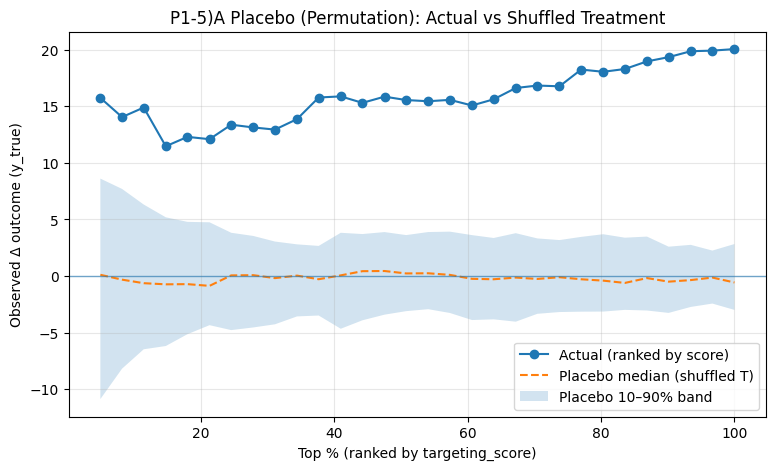

/tmp/ipython-input-3489905195.py:40: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(y[mask], x[mask])


P1-5)-A (Main outcome) AUC:
  Actual AUC: 1503.0628
  Placebo median AUC: -16.8213


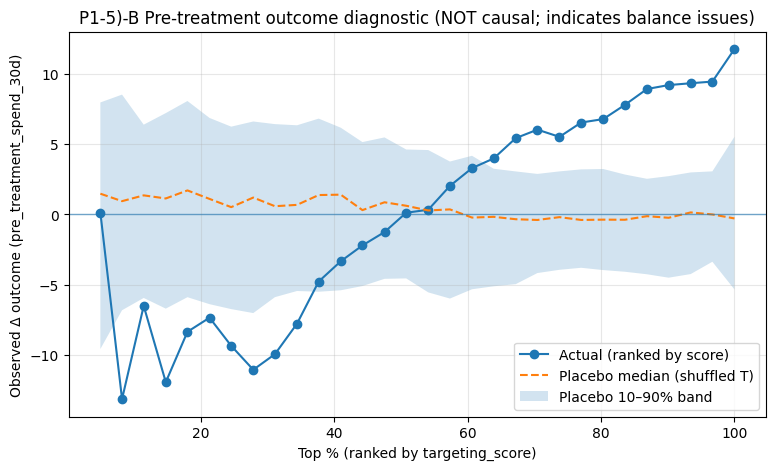


P1-5)-B (Negative control outcome) AUC:
  Actual AUC: -20.6941
  Placebo median AUC: 77.1168


/tmp/ipython-input-3489905195.py:40: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(y[mask], x[mask])


In [11]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# P1-5): Placebo / Falsification Tests (A + B)
# A) Permutation placebo on treatment (shuffle w_true)
# B) Negative control outcome (pre_treatment_spend_30d)
# ==========================================

def lift_curve_topk_diffmeans(df, score_col, outcome_col, treat_col, steps=30, min_group_n=5):
    """
    Compute a top-K curve of E[Y|T=1] - E[Y|T=0] within top-K ranked by score.
    Returns x_pct (top %), lifts (np.array with np.nan where not estimable).
    """
    temp = df[[score_col, outcome_col, treat_col]].copy()
    temp = temp.sort_values(score_col, ascending=False).reset_index(drop=True)

    n = len(temp)
    ks = np.unique(np.linspace(max(10, int(0.05*n)), n, steps).astype(int))
    lifts = []

    for k in ks:
        sub = temp.iloc[:k]
        t1 = sub[sub[treat_col] == 1][outcome_col].dropna()
        t0 = sub[sub[treat_col] == 0][outcome_col].dropna()

        if (len(t1) >= min_group_n) and (len(t0) >= min_group_n):
            lifts.append(t1.mean() - t0.mean())
        else:
            lifts.append(np.nan)

    x_pct = ks / n * 100.0
    return x_pct, np.array(lifts)

def auc_nan_safe(x, y):
    """Trapezoid AUC ignoring nan segments."""
    mask = np.isfinite(y)
    if mask.sum() < 2:
        return np.nan
    return np.trapezoid(y[mask], x[mask])

def permutation_band(df, score_col, outcome_col, treat_col, n_perm=50, steps=30, min_group_n=5, seed=42):
    """
    Run permutation placebo by shuffling treatment labels n_perm times.
    Returns x, actual_lifts, placebo_matrix (n_perm x len(x)).
    """
    rng = np.random.default_rng(seed)

    # Actual
    x, actual = lift_curve_topk_diffmeans(df, score_col, outcome_col, treat_col, steps=steps, min_group_n=min_group_n)

    # Placebos
    placebo = []
    base = df.copy()
    w = base[treat_col].values

    for _ in range(n_perm):
        w_perm = rng.permutation(w)
        tmp = base.copy()
        tmp["_w_placebo"] = w_perm
        _, lifts_p = lift_curve_topk_diffmeans(tmp, score_col, outcome_col, "_w_placebo", steps=steps, min_group_n=min_group_n)
        placebo.append(lifts_p)

    placebo = np.vstack(placebo)
    return x, actual, placebo

def plot_actual_vs_placebo_band(x, actual, placebo, title, ylabel):
    """
    Plot actual curve vs placebo band (median + 10/90 percentile).
    """
    p10 = np.nanpercentile(placebo, 10, axis=0)
    p50 = np.nanpercentile(placebo, 50, axis=0)
    p90 = np.nanpercentile(placebo, 90, axis=0)

    plt.figure(figsize=(9, 5))
    plt.plot(x, actual, marker="o", label="Actual (ranked by score)")
    plt.plot(x, p50, linestyle="--", label="Placebo median (shuffled T)")
    plt.fill_between(x, p10, p90, alpha=0.2, label="Placebo 10–90% band")
    plt.axhline(0, linewidth=1, alpha=0.6)
    plt.title(title)
    plt.xlabel("Top % (ranked by targeting_score)")
    plt.ylabel(ylabel)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()

def run_placebo_suite(df, score_col="targeting_score", treat_col="w_true",
                      outcome_main="y_true", outcome_neg="pre_treatment_spend_30d",
                      n_perm=50, steps=30, min_group_n=5):
    # ---- A) Permutation placebo on main outcome ----
    x, actual_main, placebo_main = permutation_band(
        df, score_col, outcome_main, treat_col,
        n_perm=n_perm, steps=steps, min_group_n=min_group_n, seed=42
    )
    plot_actual_vs_placebo_band(
        x, actual_main, placebo_main,
        title="P1-5)A Placebo (Permutation): Actual vs Shuffled Treatment",
        ylabel=f"Observed Δ outcome ({outcome_main})"
    )

    auc_actual = auc_nan_safe(x, actual_main)
    auc_placebo = np.nanmedian([auc_nan_safe(x, placebo_main[i]) for i in range(placebo_main.shape[0])])

    print("P1-5)-A (Main outcome) AUC:")
    print("  Actual AUC:", round(float(auc_actual), 4) if np.isfinite(auc_actual) else auc_actual)
    print("  Placebo median AUC:", round(float(auc_placebo), 4) if np.isfinite(auc_placebo) else auc_placebo)

    # ---- B) Negative control outcome ----
    if outcome_neg in df.columns:
        x2, actual_neg, placebo_neg = permutation_band(
            df, score_col, outcome_neg, treat_col,
            n_perm=n_perm, steps=steps, min_group_n=min_group_n, seed=43
        )
        plot_actual_vs_placebo_band(
            x2, actual_neg, placebo_neg,
            title="P1-5)-B Pre-treatment outcome diagnostic (NOT causal; indicates balance issues)",
            ylabel=f"Observed Δ outcome ({outcome_neg})"
        )

        auc_actual_neg = auc_nan_safe(x2, actual_neg)
        auc_placebo_neg = np.nanmedian([auc_nan_safe(x2, placebo_neg[i]) for i in range(placebo_neg.shape[0])])

        print("\nP1-5)-B (Negative control outcome) AUC:")
        print("  Actual AUC:", round(float(auc_actual_neg), 4) if np.isfinite(auc_actual_neg) else auc_actual_neg)
        print("  Placebo median AUC:", round(float(auc_placebo_neg), 4) if np.isfinite(auc_placebo_neg) else auc_placebo_neg)
    else:
        print(f"\nP1-5)-B skipped: {outcome_neg} not found in df columns.")

# Execute
run_placebo_suite(df)

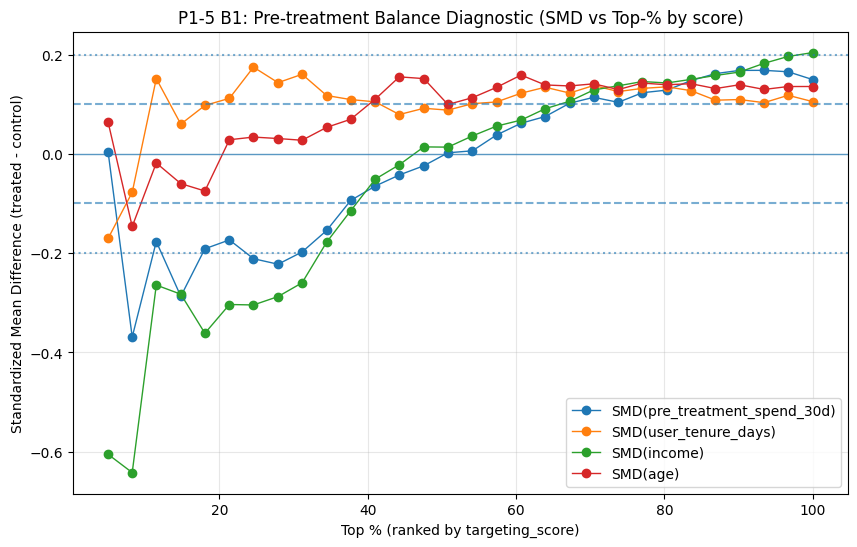

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# P1-5 B1: Pre-treatment Balance Diagnostic (SMD over Top-K)
# ==========================================

def compute_smd(x_treat, x_ctrl, eps=1e-9):
    """
    Standardized Mean Difference:
      (mean_t - mean_c) / pooled_std
    """
    mt, mc = np.mean(x_treat), np.mean(x_ctrl)
    vt, vc = np.var(x_treat, ddof=1), np.var(x_ctrl, ddof=1)
    pooled = np.sqrt((vt + vc) / 2.0) + eps
    return (mt - mc) / pooled

def smd_curve_topk(df, score_col, treat_col, feature_col, steps=30, min_group_n=20):
    """
    For each Top-K slice ranked by score, compute SMD(feature) between treated and control.
    Returns x_pct, smd_values (nan if insufficient sample).
    """
    temp = df[[score_col, treat_col, feature_col]].copy()
    temp = temp.sort_values(score_col, ascending=False).reset_index(drop=True)

    n = len(temp)
    ks = np.unique(np.linspace(max(10, int(0.05*n)), n, steps).astype(int))

    smds = []
    for k in ks:
        sub = temp.iloc[:k]
        t = sub[sub[treat_col] == 1][feature_col].dropna().values
        c = sub[sub[treat_col] == 0][feature_col].dropna().values

        if (len(t) >= min_group_n) and (len(c) >= min_group_n):
            smds.append(compute_smd(t, c))
        else:
            smds.append(np.nan)

    x_pct = ks / n * 100.0
    return x_pct, np.array(smds)

def run_balance_diagnostic(df, score_col="targeting_score", treat_col="w_true",
                           features=None, steps=30, min_group_n=20):
    """
    Plot SMD curves for multiple pre-treatment features over Top-K slices.
    """
    if features is None:
        features = ["pre_treatment_spend_30d", "user_tenure_days", "income", "age"]

    # Keep only existing columns
    features = [f for f in features if f in df.columns]
    if len(features) == 0:
        raise ValueError("No valid balance features found in df.")

    plt.figure(figsize=(10, 6))

    for f in features:
        x, smd = smd_curve_topk(df, score_col, treat_col, f, steps=steps, min_group_n=min_group_n)
        plt.plot(x, smd, marker="o", linewidth=1, label=f"SMD({f})")

    # Common balance thresholds
    plt.axhline(0.0, linewidth=1, alpha=0.7)
    plt.axhline(0.1, linestyle="--", alpha=0.6)
    plt.axhline(-0.1, linestyle="--", alpha=0.6)
    plt.axhline(0.2, linestyle=":", alpha=0.6)
    plt.axhline(-0.2, linestyle=":", alpha=0.6)

    plt.title("P1-5 B1: Pre-treatment Balance Diagnostic (SMD vs Top-% by score)")
    plt.xlabel("Top % (ranked by targeting_score)")
    plt.ylabel("Standardized Mean Difference (treated - control)")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()

# Execute
run_balance_diagnostic(df)

=== IPW Diagnostics ===
Treat rate (overall): 0.527
PS raw min/max: 0.397 / 0.867
PS clipped min/max: 0.397 / 0.867
Weight cap (q=0.99): 2.89
Weights min/max (capped): 1.19 / 2.89


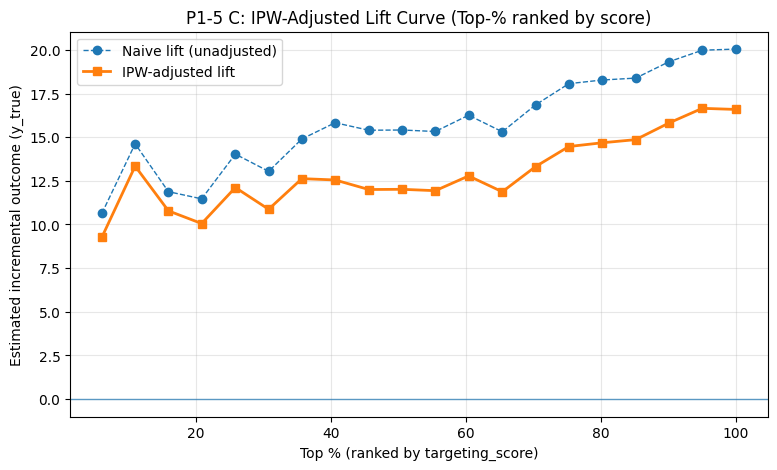

,top_pct,naive_lift,ipw_lift
0,6.013229,10.635801,9.270637
1,10.944077,14.621974,13.342957
2,15.874925,11.880414,10.781964
3,20.805773,11.469489,10.054966
4,25.796753,14.031284,12.117119


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# ==========================================
# P1-5 C: IPW-Adjusted Lift Curve (Robust Version)
# ==========================================

def run_ipw_adjusted_lift(
    df,
    score_col="targeting_score",
    outcome_col="y_true",
    treatment_col="w_true",
    features=None,
    ps_clip=(0.05, 0.95),
    weight_cap_quantile=0.99,
    steps=20,
    min_group_n=30,
    seed=42,
):
    """
    IPW lift curve in Top-K slices:
      - Fit propensity model P(T=1|X)
      - Compute stabilized weights (optional cap)
      - Compare naive vs IPW-adjusted diff-in-means over Top-% ranked by score

    Notes:
      - This is still a diagnostic/robustness check; causal claims should rely on DR/DML estimates in Notebook02.
    """
    np.random.seed(seed)
    temp = df.copy()

    if features is None:
        features = ["age", "income", "user_tenure_days", "pre_treatment_spend_30d"]
    features = [f for f in features if f in temp.columns]

    # --- Basic checks ---
    assert score_col in temp.columns, f"Missing {score_col}"
    assert outcome_col in temp.columns, f"Missing {outcome_col}"
    assert treatment_col in temp.columns, f"Missing {treatment_col}"
    if len(features) == 0:
        raise ValueError("No valid features found for propensity model.")

    # --- Handle missing values (median imputation) ---
    X = temp[features].copy()
    for c in features:
        X[c] = X[c].astype(float)
        X[c] = X[c].fillna(X[c].median())

    y_treat = temp[treatment_col].astype(int).values

    # --- Propensity model: scaler + logistic regression ---
    ps_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("lr", LogisticRegression(max_iter=2000, solver="lbfgs"))
    ])
    ps_pipe.fit(X, y_treat)
    ps = ps_pipe.predict_proba(X)[:, 1]

    # --- Clip propensity scores ---
    ps_raw_min, ps_raw_max = float(ps.min()), float(ps.max())
    ps = np.clip(ps, ps_clip[0], ps_clip[1])
    ps_min, ps_max = float(ps.min()), float(ps.max())

    # --- IPW weights ---
    w = np.where(y_treat == 1, 1.0 / ps, 1.0 / (1.0 - ps))

    # --- Cap extreme weights (winsorize) ---
    cap = float(np.quantile(w, weight_cap_quantile))
    w_capped = np.minimum(w, cap)

    temp["_ps"] = ps
    temp["_w_ipw"] = w_capped

    # Diagnostics
    treat_rate = float(temp[treatment_col].mean())
    print("=== IPW Diagnostics ===")
    print(f"Treat rate (overall): {treat_rate:.3f}")
    print(f"PS raw min/max: {ps_raw_min:.3f} / {ps_raw_max:.3f}")
    print(f"PS clipped min/max: {ps_min:.3f} / {ps_max:.3f}")
    print(f"Weight cap (q={weight_cap_quantile}): {cap:.2f}")
    print(f"Weights min/max (capped): {float(w_capped.min()):.2f} / {float(w_capped.max()):.2f}")

    # --- Sort by targeting score (descending) ---
    temp = temp.sort_values(score_col, ascending=False).reset_index(drop=True)

    n = len(temp)
    ks = np.unique(np.linspace(max(100, int(0.05 * n)), n, steps).astype(int))
    x_pct = ks / n * 100.0

    naive_lifts, ipw_lifts = [], []
    for k in ks:
        sub = temp.iloc[:k]

        t1 = sub[sub[treatment_col] == 1]
        t0 = sub[sub[treatment_col] == 0]

        # Guard against tiny groups in Top-K
        if (len(t1) < min_group_n) or (len(t0) < min_group_n):
            naive_lifts.append(np.nan)
            ipw_lifts.append(np.nan)
            continue

        # Naive diff-in-means
        naive = float(t1[outcome_col].mean() - t0[outcome_col].mean())
        naive_lifts.append(naive)

        # IPW-adjusted weighted means
        w1 = t1["_w_ipw"].values
        w0 = t0["_w_ipw"].values

        # Avoid division by zero
        denom1 = w1.sum()
        denom0 = w0.sum()
        if denom1 <= 1e-9 or denom0 <= 1e-9:
            ipw_lifts.append(np.nan)
            continue

        mu1 = float((t1[outcome_col].values * w1).sum() / denom1)
        mu0 = float((t0[outcome_col].values * w0).sum() / denom0)
        ipw_lifts.append(mu1 - mu0)

    # --- Plot ---
    plt.figure(figsize=(9, 5))
    plt.plot(x_pct, naive_lifts, linestyle="--", marker="o", linewidth=1, label="Naive lift (unadjusted)")
    plt.plot(x_pct, ipw_lifts, linestyle="-", marker="s", linewidth=2, label="IPW-adjusted lift")
    plt.axhline(0, linewidth=1, alpha=0.7)
    plt.title("P1-5 C: IPW-Adjusted Lift Curve (Top-% ranked by score)")
    plt.xlabel("Top % (ranked by targeting_score)")
    plt.ylabel(f"Estimated incremental outcome ({outcome_col})")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()

    return pd.DataFrame({"top_pct": x_pct, "naive_lift": naive_lifts, "ipw_lift": ipw_lifts})

# Execute
ipw_curve_df = run_ipw_adjusted_lift(df)
display(ipw_curve_df.head())

##
Balance diagnostic (B1) shows meaningful imbalance in top-ranked slices (notably baseline spend and income), so naive diff-in-means lift may be biased.

IPW-adjusted lift curve (C) corrects for observed imbalance using propensity weighting; estimates are numerically stable (PS range ~0.40–0.87; capped weights ≤ 2.89).

After adjustment, uplift remains clearly positive across slices and follows a consistent increasing pattern as targeting expands, suggesting the ranking captures genuine treatment responsiveness rather than pure selection bias.

##
Lessons Learned

A clean “score contract” makes everything downstream modular. Separating a rank-based targeting_score (for selection/top-K) from a dollar-based targeting_uplift (for profit accounting) allowed us to plug the same model outputs into multiple policies (threshold, budget) without rewriting logic.

Profit layers turn uplift into decision-making, not just evaluation. Converting incremental spend into incremental profit via margin and cost revealed practical trade-offs (coverage vs ROI vs total profit) that are invisible in purely model-centric metrics.

Top-ranked slices can be the least balanced. The pre-treatment diagnostic and SMD-by-top-% plot showed that the highest-scoring users may have meaningful baseline differences between treated and control groups, which can bias naive lift curves if not addressed.

Stress tests should be a suite, not a single check. Randomized-treatment permutation placebo provided a strong falsification baseline, while pre-treatment outcome diagnostics flagged imbalance risks. Using multiple stress tests improved confidence and made failure modes interpretable.

Adjustment methods make estimates more conservative but more credible. IPW-adjusted lift curves typically reduced the naive uplift magnitude while preserving positive signal, suggesting that part of the apparent effect was selection-driven, but the model still captured genuine treatment responsiveness.

Segmentation bridges model outputs to business insight. Quad-tree segmentation (uplift × baseline propensity) and policy-based profile contrasts helped translate “who to target” into “what kinds of users we are targeting and why,” supporting more actionable messaging for stakeholders.